In [1]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /private/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/pip-req-build-rka7k4rn
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /private/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/pip-req-build-rka7k4rn
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done


In [2]:
!pip install efficientnet-pytorch

In [1]:
import time
import skimage.io
from skimage.transform import resize
import sys
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import math
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

--- 

## resize (background delete) - K means - score evaluation - apply crop

In [2]:
os.getcwd()

'/Users/krc/Documents/breast_dacon/dacon_bc_prediction'

In [5]:
from numpy.linalg import norm
import copy 

#From t.ly/TLq_


class KMeans():
    def __init__(self, n_clusters, max_iter = 20, random_state = 60):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        
    def initialize_centroids(self, X): # center 초기화 - 이미지 내 특정 점으로 고정
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]

        return centroids
        
    def compute_centroids(self, X, labels): # centroids 계산 
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids
        
    def compute_distance(self, X, centroids): #
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance
    
    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)
    
    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
 
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
        # return self.labels
        
    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)

In [6]:
#run 

# file_path = '/Users/krc/Documents/breast_dacon/train_imgs/'
# file_list = os.walk(file_path)  # OS로 불러오기
# img_files = [file for file in file_list if file[-1][-1].endswith(".png")]



# if not img_files:  # if empty folder
#     print("there are no png files")
#     sys.exit()

# for i, f in enumerate(img_files[0][2]):
#     if i% 20 == 0:
#         print(f'index {i} is starting.. ')
#     # t.ly/zgLP
#     image = cv2.imread(file_path + f)
#     y_orig, x_orig, channel= image.shape
#     if x_orig / y_orig < 1.5:
#         cv2.imwrite(f'./new_train/{f}', image)
#         print(f'{f} has one image')
#         continue
#     gray_sample = image.copy()
#     gray_sample = cv2.cvtColor(gray_sample, cv2.COLOR_RGB2GRAY)
    
#     # 모양 맞추기 flip 
#     gray_sample =cv2.flip(gray_sample, 0)
#     # resize to 400 * 200
#     gray_sample = cv2.resize(gray_sample, dsize=(400, 200), interpolation=cv2.INTER_LINEAR) 
    
#     #전처리
#     coord = np.where( gray_sample < 239 )
#     co_array = np.array(coord)
#     co_array = np.float32(co_array).T
#     from sklearn.metrics import silhouette_samples, silhouette_score

#     best_score = 0
#     best_k = 1
#     best_centroids = []

#     for j, k in enumerate([ 4, 3, 2]):
        
#         # Run the Kmeans algorithm
#         km = KMeans(n_clusters=k)
#         km.fit(co_array)
#         labels = km.predict(co_array) # input data

#         centroids = km.compute_centroids(co_array, labels) # cluster_centers_
#         # Get silhouette samples
#         silhouette_vals = silhouette_samples(co_array, labels)

#         # Get the average silhouette score and plot it
#         avg_score = np.mean(silhouette_vals) ## score 

#         # print('K = ',k, 'avg_score:', avg_score)

#         if best_score < avg_score:
#             if best_k == 3 and k ==2 and (avg_score-best_score) < 0.09:
#                 break
#             best_score = avg_score
#             best_k = k
#             best_centroids = centroids
#             x_coord = centroids[ : , 1]
#             x_coord.sort()        
#             if best_k == 2:
#                 x1, x2 = x_coord
#             elif best_k ==3  :
#                 x1, x2, x3 = x_coord
#             elif best_k ==4  :
#                 x1, x2, x3, x4 = x_coord

#     if best_k == 2:
#         crop_image = image[:, : int( (x1+x2)/2  *x_orig / 400 ), :]
#     elif best_k > 2:
#         alpha = int(y_orig / 2)
#         crop_image = image[:, max(0, int(x2 *x_orig /400) -alpha)  :int(x2 *x_orig /400) +alpha , : ] ## 마이너스나옴 

#     cv2.imwrite(f'./new_train/{f}', crop_image)
    
    

In [7]:
# # test imgs run 
# file_path = '/Users/krc/Documents/breast_dacon/test_imgs/'
# file_list = os.walk(file_path)  # OS로 불러오기
# img_files = [file for file in file_list if file[-1][-1].endswith(".png")]



# if not img_files:  # if empty folder
#     print("there are no png files")
#     sys.exit()

# for i, f in enumerate(img_files[0][2]):
#     if i% 20 == 0:
#         print(f'index {i} is starting.. ')
#     # t.ly/zgLP
#     image = cv2.imread(file_path + f)
#     y_orig, x_orig, channel= image.shape
#     if x_orig / y_orig < 1.5:
#         cv2.imwrite(f'./new_test/{f}', image)
#         print(f'image {f} has one image')
#         continue
#     gray_sample = image.copy()
#     gray_sample = cv2.cvtColor(gray_sample, cv2.COLOR_RGB2GRAY)
    
#     # 모양 맞추기 flip 
#     gray_sample =cv2.flip(gray_sample, 0)
#     # resize to 400 * 200
#     gray_sample = cv2.resize(gray_sample, dsize=(400, 200), interpolation=cv2.INTER_LINEAR) 
    
#     #전처리
#     coord = np.where( gray_sample < 239 )
#     co_array = np.array(coord)
#     co_array = np.float32(co_array).T
#     from sklearn.metrics import silhouette_samples, silhouette_score

#     best_score = 0
#     best_k = 1
#     best_centroids = []

#     for j, k in enumerate([ 4, 3, 2]):
        
#         # Run the Kmeans algorithm
#         km = KMeans(n_clusters=k)
#         km.fit(co_array)
#         labels = km.predict(co_array) # input data

#         centroids = km.compute_centroids(co_array, labels) # cluster_centers_
#         # Get silhouette samples
#         silhouette_vals = silhouette_samples(co_array, labels)

#         # Get the average silhouette score and plot it
#         avg_score = np.mean(silhouette_vals) ## score 

#         # print('K = ',k, 'avg_score:', avg_score)

#         if best_score < avg_score:
#             if best_k == 3 and k ==2 and (avg_score-best_score) < 0.09:
#                 break
#             best_score = avg_score
#             best_k = k
#             best_centroids = centroids
#             x_coord = centroids[ : , 1]
#             x_coord.sort()        
#             if best_k == 2:
#                 x1, x2 = x_coord
#             elif best_k ==3  :
#                 x1, x2, x3 = x_coord
#             elif best_k ==4  :
#                 x1, x2, x3, x4 = x_coord

#     if best_k == 2:
#         crop_image = image[:, : int( (x1+x2)/2  *x_orig / 400 ), :]
#     elif best_k > 2:
#         alpha = int(y_orig / 2)
#         crop_image = image[:, max(0, int(x2 *x_orig /400) -alpha)  :int(x2 *x_orig /400) +alpha , : ] ## 마이너스나옴 

#     cv2.imwrite(f'./new_test/{f}', crop_image)
    
    

--- 
## Model input
### config

In [3]:
data_dir = './new_train'
df_train = pd.read_csv('/Users/krc/Documents/breast_dacon/open/train.csv')
df_test = pd.read_csv('/Users/krc/Documents/breast_dacon/open/test.csv')

image_folder = data_dir

enet_type = 'efficientnet-b4'
fold=0
tile_size = 200
image_size = 200
n_tiles = 36 
batch_size = 2
num_workers = 0
out_dim = 1
init_lr  = 3e-4
warmup_factor = 20

warmup_epo = 1
n_epochs = 30

print(image_folder)

./new_train


In [4]:
device = torch.device('cpu')

In [10]:
# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

## Create Folds

In [5]:
skf = StratifiedKFold(5, shuffle = True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['N_category'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

ID                     img_path mask_path  나이       수술연월일  진단명  \
0  BC_01_0001  ./train_imgs/BC_01_0001.png         -  63  2015-10-23    1   
1  BC_01_0002  ./train_imgs/BC_01_0002.png         -  51  2015-10-28    1   
2  BC_01_0003  ./train_imgs/BC_01_0003.png         -  37  2015-10-29    1   
3  BC_01_0004  ./train_imgs/BC_01_0004.png         -  54  2016-03-08    1   
4  BC_01_0005  ./train_imgs/BC_01_0005.png         -  57  2015-10-30    1   

   암의 위치  암의 개수  암의 장경   NG  ...   PR  PR_Allred_score  KI-67_LI_percent  \
0      2      1   19.0  2.0  ...  1.0              6.0              12.0   
1      1      1   22.0  3.0  ...  0.0              NaN              70.0   
2      2      1    NaN  2.0  ...  1.0              4.0               7.0   
3      2      1    0.0  3.0  ...  0.0              NaN               1.0   
4      2      1    8.0  2.0  ...  0.0              NaN               8.0   

   HER2  HER2_IHC  HER2_SISH  HER2_SISH_ratio  BRCA_mutation  N_category  fold  
0   0.0       1.0        NaN              NaN            NaN           0     4  
1   0.0       0.0        NaN              NaN            NaN           1     2  
2   0.0       1.0        NaN              NaN            0.0           0     2  
3   1.0       3.0        NaN              NaN            NaN           0     4  
4   1.0       2.0        1.0             5.44            NaN           0     4  

[5 rows x 29 columns]

In [6]:
enet = models.efficientnet_b4(weights=True)
enet.features[-2] == enet.features[7]

True

In [7]:
class enetv4(nn.Module):
    def __init__(self, out_dim):
        super(enetv4, self).__init__()
        self.enet = models.efficientnet_b4(weights=True)
        for param in enet.features[7].parameters():
            param.requires_grad= False
        for param in enet.features[-2:].parameters():
            param.requires_grad= True
        
        self.myfc = nn.Linear(self.enet.classifier[1].in_features, out_dim)
        self.enet.classifier = nn.Identity()
        
    def extract(self, x):
        return self.enet(x)
    
    def forward(self, x):
        x= self.extract(x)
        x = self.myfc(x)
        return x

## Dataset

In [8]:
def get_tiles(img, mode=0):
    result = []
    h, w, c = img.shape
    pad_h = (tile_size -h % tile_size) % tile_size + ((tile_size * mode) // 2)
    pad_w = (tile_size -w % tile_size) % tile_size + ((tile_size * mode) // 2)
    
    img2 = np.pad(img, [[pad_h // 2, pad_h - pad_h//2], [pad_w //2, pad_w - pad_w //2], [0,0]], constant_values = 255)
    img3 = img2.reshape( 
                        img2.shape[0] // tile_size, 
                        tile_size, 
                        img2.shape[1] // tile_size, 
                        tile_size,
                        3 )
    img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size, 3)
    n_tiles_with_info = (img3.reshape(img3.shape[0], -1).sum(1) < tile_size ** 2 * 3 * 255).sum()
    if len(img3) < n_tiles :
        img3 = np.pad(img3, [[0, n_tiles -len(img3)], [0,0], [0,0], [0,0]], constant_values = 255)
    idxs = np.argsort(img3.reshape(img3.shape[0], -1).sum(-1))[:n_tiles]
    img3 = img3[idxs]
    for i in range(len(img3)):
        result.append({'img':img3[i], 'idx':i})
    return result, n_tiles_with_info >= n_tiles
        
        
class PANDADataset(Dataset):
        def __init__(self, df, image_size, n_tiles = n_tiles, tile_mode =0, rand=False, transform = None):
        
            self.df = df.reset_index(drop = True)
            self.image_size = image_size
            self.n_tiles = n_tiles
            self.tile_mode = tile_mode
            self.rand = rand
            self.transform = transform
        
        def __len__(self):
            return self.df.shape[0]
        
        def __getitem__(self, index):
            row = self.df.iloc[index]
            #img_id = row.image_id
        

            tiff_file = image_folder + self.df['img_path'].iloc[index][-15:]
            image = skimage.io.imread(tiff_file) #image = skimage.io.MultiImage(tiff_file)[1]
#             resize 
#             shape_w, shape_h, _ = image.shape
#             image = resize(image, (1200, 1200), anti_aliasing = True) 
            
            tiles, OK = get_tiles(image, self.tile_mode)
        
            if self.rand:
                idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace = False)
            else:
                idxes = list(range(self.n_tiles))
                
            n_row_tiles = int(np.sqrt(self.n_tiles))
            images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
            
            for h in range(n_row_tiles):
                for w in range(n_row_tiles):
                    i = h* n_row_tiles + w
                    
                    if len(tiles) > idxes[i]:
                        this_img = tiles[idxes[i]]['img']
                    else:
                        this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                    
                    this_img = 255 - this_img
                    if self.transform is not None:
                        this_img = self.transform(image = this_img)['image']
                    h1 = h * image_size
                    w1 = w * image_size
                    images[h1:h1+image_size, w1:w1+image_size] = this_img 
                    
            if self.transform is not None:
                images = self.transform(image = images)['image']
            images = images.astype(np.float32)
            images /= 255
            images = images.transpose(2,0,1)
            
            label  = row.N_category
            return torch.tensor(images), torch.tensor(label)
        
            

## Augmentations

In [9]:
transforms_train = albumentations.Compose([
    albumentations.Transpose( p=0.5),
    albumentations.VerticalFlip( p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

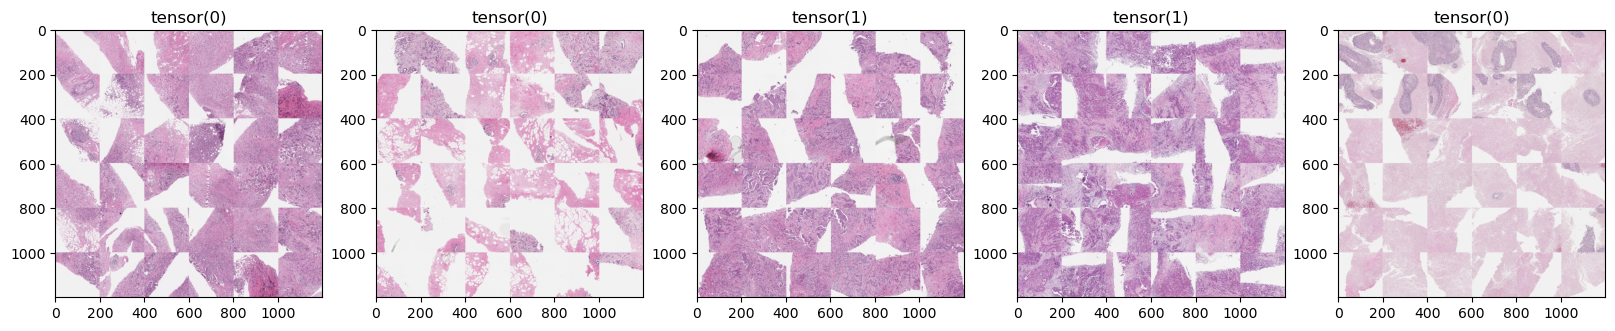

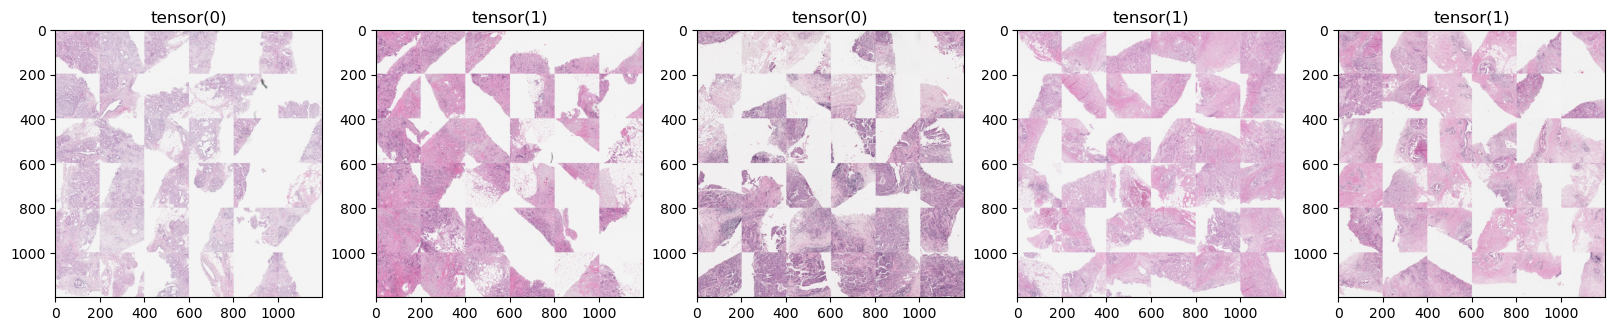

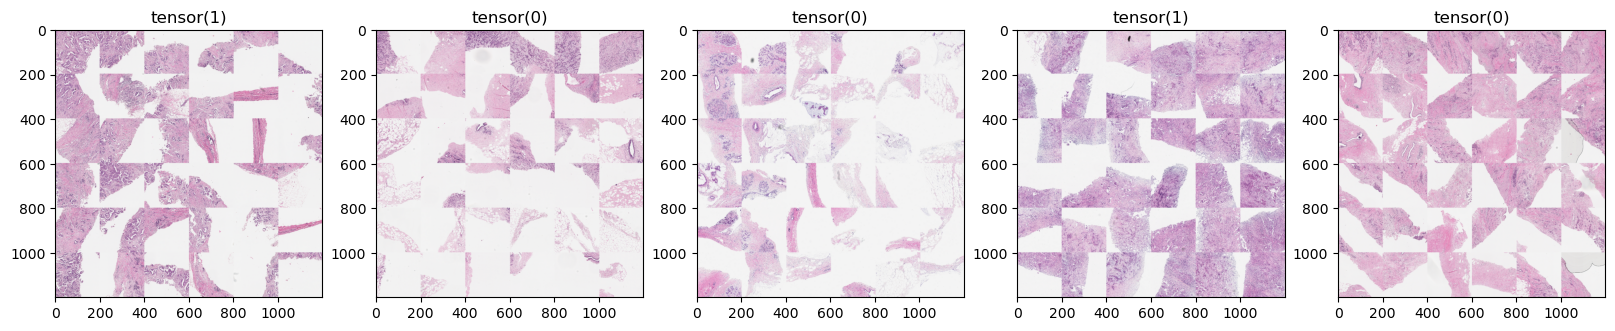

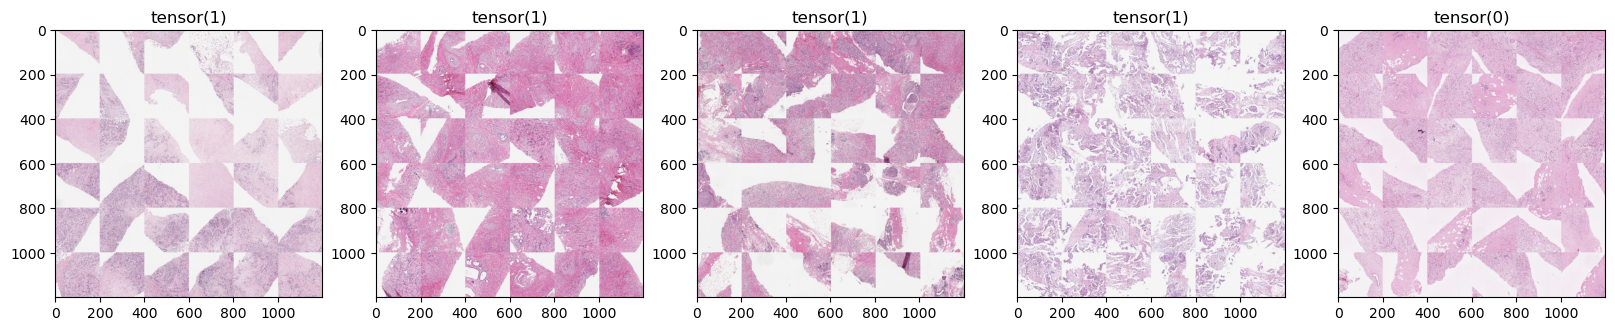

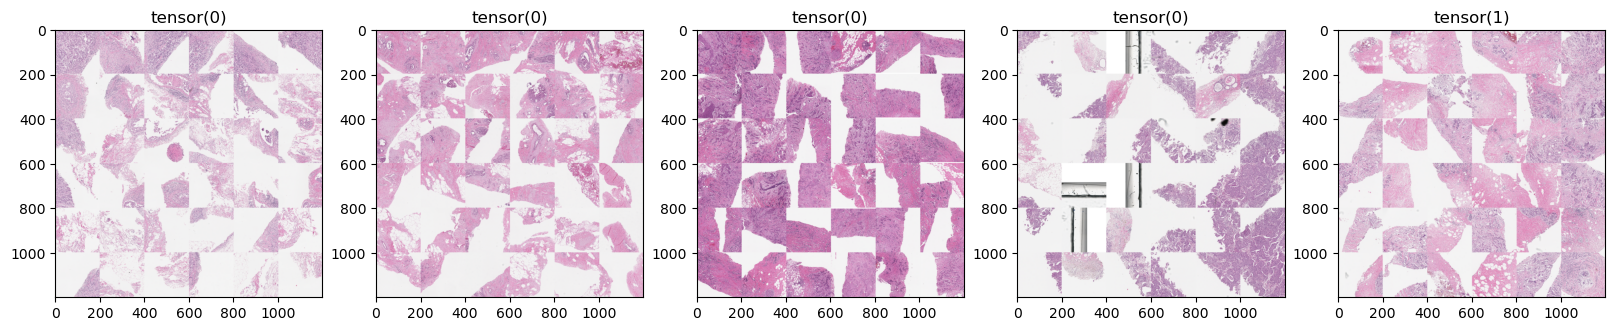

In [10]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)


from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(5):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(str((label)))

In [11]:
# loss

criterion = nn.BCEWithLogitsLoss()

## Train & val

In [18]:
def train_epoch(loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        target = target.unsqueeze(dim = 1).float()
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss),100)
        bar.set_description( 'loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss

def val_epoch(loader, get_output = False):
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            
            loss = criterion(logtis, target)
            
            pred = logits.sigmoid().detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target)
            
            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)
                           
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights = 'quadratic')
#     qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].N_category.values, weights = 'quadratic')
#     qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'])
    print('qwk:', qwk)
    
    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

## create dataloader & model & optimizer

In [19]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this, image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, sampler = RandomSampler(dataset_train), num_workers= num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size = batch_size, sampler = SequentialSampler(dataset_valid), num_workers = num_workers)

model = enetv4(out_dim = out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier = warmup_factor, total_epoch = warmup_epo, after_scheduler= scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

800 200


In [20]:
qwk_max = 0

best_file = f'./pth/b4_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'epoch:', epoch)
    scheduler.step(epoch-1)
    
    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), f'./pth/b4_final_fold{fold}_{qwk[:4]}.pth')

Mon Nov 21 15:04:42 2022 epoch: 1


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'logtis' is not defined

---

## inference

In [ ]:
test_dataset = CustomDataset(test_df, None, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [27]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    threshold = 0.5
    
    with torch.no_grad():
        for img in tqdm(iter(test_loader)): # , tabular   = 2nd
            img = img.float().to(device)
            # tabular = tabular.float().to(device)
            
            model_pred = model(img)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    preds = np.where(np.array(preds) > threshold, 1, 0)
    
    return preds

In [28]:
submit = pd.read_csv('../open/sample_submission.csv')

In [ ]:
submit['N_category'] = preds
submit.to_csv('./submit.csv', index=False)

In [61]:
a = list(np.zeros(50))
b = list(np.ones(50))
answer = a+b

len(answer)

100

In [74]:
z = list(np.random.randint(2, size=(100,1)))
len(z)

100

In [75]:
import sklearn

sklearn.metrics.f1_score(answer, z)

0.5148514851485149

In [71]:
label = np.zeros(5)
label[:] =1

In [72]:
label

array([0., 0., 0., 0., 0.])

In [77]:
df_train.iloc[5].N_category

0